In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module.geospatial_utils.raster_interaction import (
    random_raster_gdf,
    subset_gebco,
)
from atl_module import GebcoUpscaler
from atl_module.kriging import krige_bathy
from atl_module.error_calc import raster_RMSE_blocked
from atl_module.kalman import gridded_kalman_update
from atl_module.geospatial_utils.raster_interaction import query_from_lines
import geopandas as gpd
import pandas as pd
from atl_module.plotting import set_size
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show as rastershow

In [3]:
site = "stcroix"
truthraster_path = f"../data/for_other_figures/stcroixvalidation.tif"
tracklines = gpd.read_file(f"../data/test_sites/{site}/tracklines/")

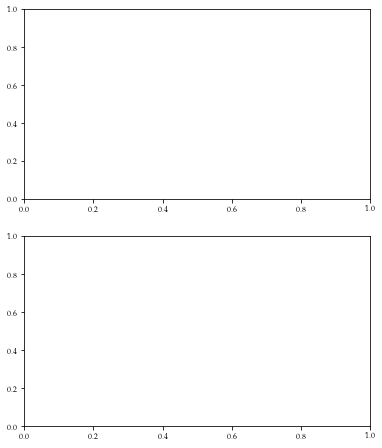

In [4]:
fig, (topax, bottomax) = plt.subplots(
    figsize=set_size(fraction=1, ratio=1.618 / 2), nrows=2
)

In [5]:
gdf = random_raster_gdf(truthraster_path, 10000)
gdf = gdf.rename(columns={"truth raster elevation": "sf_elev_MSL"})

In [6]:
gdf.to_file("../data/truthraster_sampling/random_pts.gpkg")
# the kriging function needs projected coordinates
gdf = gdf.to_crs(gdf.estimate_utm_crs())
# kriging function depends on these exact column names
gdf = gdf.rename(columns={"truth raster elevation": "sf_elev_MSL"})

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [7]:
# get the GEBCO subsample based on the current point extent
hres = 50
subset_gebco(
    "../data/truthraster_sampling", bathy_pts=gdf, epsg_no=gdf.crs.to_epsg(), hres=hres
)

# mask any points that are above the seafloor
gdf = gdf[gdf.sf_elev_MSL < 0]

[D 220929 16:39:04 raster_interaction:149] GEBCO subset raster written to ../data/truthraster_sampling/bilinear.tif, with CRS EPSG:32620


In [8]:
# do the kriging of the random sampling points
krige_bathy(
    kr_model="uk",
    folderpath="../data/truthraster_sampling",
    npts=2000,
    variogram_model="spherical",
    pts_gdf_all=gdf,
    crs=gdf.crs,
    samplemethod="dart",
    variogram_parameters={"range": 10000, "nugget": 0, "sill": 23},
)
gdf_sampled_random = gpd.read_file("../data/truthraster_sampling/kriging_pts/")

[D 220929 16:39:04 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f4')])
[D 220929 16:39:04 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220929 16:39:05 kriging:79] 2000 points selected with dart written to ../data/truthraster_sampling/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 23
Full Sill: 23
Range: 10000
Nugget: 0 

Calculating statistics on variogram model fit...
Q1 = 0.0315834601945838
Q2 = 4.802751127075775
cR = 2.1019577369901032 

Initializing drift terms...
Executing Universal Kriging...



[D 220929 16:43:13 kriging:134] finished kriging, now saving the output raster to ../data/truthraster_sampling/kriging_output.tif
[D 220929 16:43:13 kriging:152] Output raster of kriged Z values and uncertainty saved sucessfully


In [9]:
with rasterio.open(truthraster_path) as femaras:
    topax.set_xlabel(f"Degrees longitude in {femaras.crs}")
    topax.set_ylabel(f"Degrees latitude in {femaras.crs}")
    # cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=femaras.crs)
    image_hidden = topax.imshow(
        femaras.read(1, masked=True),
        cmap="inferno",
    )
    gdf_sampled_random.to_crs("EPSG:4269").plot(
        figsize=(20, 12), ax=topax, markersize=3
    )
    rastershow(femaras, cmap="inferno", ax=topax, vmax=0)

<Figure size 432x288 with 0 Axes>

In [10]:
bilinear_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/bilinear.tif",
)

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))


In [11]:
assumed_gebco_variance = 1.5

In [12]:
purekriged_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kriging_output.tif",
)
gridded_kalman_update(
    "../data/truthraster_sampling/kalman_update.tif",
    "../data/truthraster_sampling/bilinear.tif",
    "../data/truthraster_sampling/kriging_output.tif",
    assumed_gebco_variance,
)
kalman_updated_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kalman_update.tif",
)

[I 220929 16:43:29 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/truthraster_sampling/kalman_update.tif


old val to beat: 2.358246

# sampling along lines

In [13]:
# set up a function that accepts a list of tuples, and returns a list of z values
truthsampler = lambda x: query_from_lines(x, truthraster_path, 1)
# apply the function to the geometry and split it into a series
sampled_lines = tracklines.geometry.apply(truthsampler).apply(pd.Series)
# get arrays of the xyz points
xvals = sampled_lines[0].apply(pd.Series).to_numpy().flatten()
yvals = sampled_lines[1].apply(pd.Series).to_numpy().flatten()
zvals = sampled_lines[2].apply(pd.Series).to_numpy().flatten()
# convert these xyz points to a gdf
points_along_lines = gpd.GeoDataFrame(
    zvals, geometry=gpd.points_from_xy(xvals, yvals), crs="EPSG:4326"
)
# project to local UTM and save it
points_along_lines = points_along_lines.to_crs(points_along_lines.estimate_utm_crs())
# drop points where we have no value
points_along_lines = points_along_lines.rename(columns={0: "sf_elev_MSL"}).dropna()
# drop points on land
points_along_lines = points_along_lines[points_along_lines.sf_elev_MSL < 0]
points_along_lines.to_file("../data/truthraster_sampling/points_along_lines.gpkg")

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [14]:
# subset gebco again with the neew bathy points
hres = 50
subset_gebco(
    "../data/truthraster_sampling",
    bathy_pts=points_along_lines,
    epsg_no=points_along_lines.crs.to_epsg(),
    hres=hres,
)

[D 220929 16:43:56 raster_interaction:149] GEBCO subset raster written to ../data/truthraster_sampling/bilinear.tif, with CRS EPSG:32620


In [15]:
# this is extremely ugly, but the kriging function requires a points path with this specific name
krige_bathy(
    kr_model="uk",
    folderpath="../data/truthraster_sampling",
    npts=2000,
    variogram_model="spherical",
    pts_gdf_all=points_along_lines,
    crs=points_along_lines.crs,
    samplemethod="dart",
    variogram_parameters={"range": 10000, "nugget": 0, "sill": 23},
)

[D 220929 16:43:56 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f8')])
[D 220929 16:43:56 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220929 16:43:57 kriging:79] 2000 points selected with dart written to ../data/truthraster_sampling/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 23
Full Sill: 23
Range: 10000
Nugget: 0 

Calculating statistics on variogram model fit...
Q1 = 0.016649087548681125
Q2 = 5.237062406602124
cR = 1.6883416355559766 

Initializing drift terms...
Executing Universal Kriging...



[D 220929 16:49:08 kriging:134] finished kriging, now saving the output raster to ../data/truthraster_sampling/kriging_output.tif
[D 220929 16:49:08 kriging:152] Output raster of kriged Z values and uncertainty saved sucessfully


Add the data for the bottom axis

In [16]:
gdf_sampled_lines = gpd.read_file("../data/truthraster_sampling/kriging_pts/")

with rasterio.open(truthraster_path) as femaras:

    bottomax.set_xlabel(f"Degrees longitude in {femaras.crs}")
    bottomax.set_ylabel(f"Degrees latitude in {femaras.crs}")
    # cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=femaras.crs)
    image_hidden = bottomax.imshow(femaras.read(1, masked=True), cmap="inferno", vmax=0)
    gdf_sampled_lines.to_crs("EPSG:4269").plot(
        figsize=(20, 12), ax=bottomax, markersize=4
    )
    rastershow(femaras, cmap="inferno", ax=bottomax, vmax=0)

fig.colorbar(image_hidden, ax=[topax, bottomax])

<Figure size 432x288 with 0 Axes>

save the final figure as a PDF

In [17]:
fig.savefig(
    "../document/figures/truthraster_sampling_combined.pdf",
    dpi=500,
    bbox_inches="tight",
)

# Error summary and output to a table

Get the error metrics between the various raster combinations

In [18]:
purekriged_rmse_lines = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kriging_output.tif",
)

gridded_kalman_update(
    "../data/truthraster_sampling/kalman_update.tif",
    "../data/truthraster_sampling/bilinear.tif",
    "../data/truthraster_sampling/kriging_output.tif",
    gebco_uncertainty_in=assumed_gebco_variance,
)
kalman_updated_rmse_lines = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kalman_update.tif",
)

[I 220929 16:49:25 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/truthraster_sampling/kalman_update.tif
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))


In [25]:
rmse_dict = {
    ("", f"Truth vs GEBCO"): bilinear_rmse,
    ("Random sampling", "Truth vs Kriging"): purekriged_rmse,
    ("Random sampling", "Truth vs Kalman updated"): kalman_updated_rmse,
    ("Colinear sampling", "Truth Vs Kriging"): purekriged_rmse_lines,
    ("Colinear sampling", "Truth Vs Kalman updated"): kalman_updated_rmse_lines,
}
truthraster_sampling_table = pd.DataFrame.from_dict(rmse_dict, orient="columns").T

truthraster_sampling_table.style.format(precision=2).to_latex(
    "../document/tables/truth_raster_sample_error.tex",
    caption="Comparison of error between the two different sampling strategies ",
    hrules=True,
    position_float="centering",
    clines="skip-last;index",
    label="tab:random-vs-colinear-sampling",
)

truthraster_sampling_table

RMSE       MAE
                  Truth vs GEBCO           4.477120  3.308975
Random sampling   Truth vs Kriging         3.128921  1.181509
                  Truth vs Kalman updated  1.379315  0.891389
Colinear sampling Truth Vs Kriging         4.486919  2.121551
                  Truth Vs Kalman updated  1.968372  1.316403